In [ ]:
%pip install -q -U keras-tuner
%pip install -q -U tensorboard-plugin-profile

In [31]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

## Data Fetching

In [32]:
from utils.data_fetch import read_data
data = read_data()

C:\Users\Vardan\AppData\Local\Temp\ipykernel_15044\1164869249.py:2: DeprecationWarning: [Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types
  data = read_data()


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Spindle Speed     27 non-null     float64
 1   Feed (mm/min)     27 non-null     float64
 2   Tool Dia. (mm)    27 non-null     float64
 3   MRR (mm^3 / min)  27 non-null     float64
 4   L_e               27 non-null     float64
dtypes: float64(5)
memory usage: 1.2 KB


## Data Preprocessing

In [34]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=32)

In [35]:
X_train_full = train_set.drop(["L_e", "MRR (mm^3 / min)"], axis = 1)
y_train_full =pd.concat([train_set["L_e"], train_set["MRR (mm^3 / min)"]], axis=1)

In [36]:
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=32)

In [37]:
X_train = train_set.drop(["L_e", "MRR (mm^3 / min)"], axis = 1)
y_train=pd.concat([train_set["L_e"], train_set["MRR (mm^3 / min)"]], axis=1)

In [38]:
X_val = val_set.drop(["L_e", "MRR (mm^3 / min)"], axis = 1)
y_val=pd.concat([val_set["L_e"], val_set["MRR (mm^3 / min)"]], axis=1)

In [39]:
X_test = test_set.drop(["L_e", "MRR (mm^3 / min)"], axis = 1)
y_test=pd.concat([test_set["L_e"], test_set["MRR (mm^3 / min)"]], axis=1)

In [40]:
X_train.shape

(16, 3)

In [41]:
norm_layer = keras.layers.Normalization(input_shape=X_train.shape[1:])

In [42]:
model = keras.models.Sequential([
    norm_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(2)
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["RootMeanSquaredError", "mse"])
norm_layer.adapt(X_train)

In [43]:
X_train.shape

(16, 3)

In [44]:
y_train.shape

(16, 2)

In [45]:
X_val.shape

(5, 3)

In [46]:
y_val.shape

(5, 2)

In [47]:
from pathlib import Path
from time import strftime
def get_run_logdir(root_logdir="my_logs"):
 return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir() 

In [48]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 3)                 7         
 on)                                                             
                                                                 
 batch_normalization (Batch  (None, 3)                 12        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 500)               2000      
                                                                 
 batch_normalization_1 (Bat  (None, 500)               2000      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                        

In [50]:
history = model.fit(X_train,y_train, epochs=500, verbose=1, callbacks=[ early_stopping_cb],validation_data=(X_val,y_val))

Epoch 1/500

1/1 [==============================] - 4s 4s/step - loss: 21.1289 - root_mean_squared_error: 4.5966 - mse: 21.1289 - val_loss: 39.1078 - val_root_mean_squared_error: 6.2536 - val_mse: 39.1078
Epoch 2/500
1/1 [==============================] - 0s 76ms/step - loss: 11.1828 - root_mean_squared_error: 3.3441 - mse: 11.1828 - val_loss: 36.5252 - val_root_mean_squared_error: 6.0436 - val_mse: 36.5252
Epoch 3/500
1/1 [==============================] - 0s 66ms/step - loss: 6.5582 - root_mean_squared_error: 2.5609 - mse: 6.5582 - val_loss: 34.7445 - val_root_mean_squared_error: 5.8944 - val_mse: 34.7445
Epoch 4/500
1/1 [==============================] - 0s 53ms/step - loss: 3.6094 - root_mean_squared_error: 1.8999 - mse: 3.6094 - val_loss: 33.0635 - val_root_mean_squared_error: 5.7501 - val_mse: 33.0635
Epoch 5/500
1/1 [==============================] - 0s 47ms/step - loss: 1.8011 - root_mean_squared_error: 1.3421 - mse: 1.8011 - val_loss: 31.4380 - val_root_mean_squared_error: 5.6

KeyboardInterrupt: 

In [ ]:
rmse_score = model.evaluate(X_test,y_test)

In [ ]:
X_new = X_train[:3]

In [ ]:
X_train[:3]

In [ ]:
model.predict(X_new)

In [ ]:
y_train[:3]

### Model Tuning

In [ ]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=100, max_value=500)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,sampling="log")
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = keras.Sequential()
    model.add(norm_layer)
    for _ in range(n_hidden):
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dense(2))
    model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
    return model

In [ ]:
tuner = kt.RandomSearch(
 build_model, objective=kt.Objective("val_root_mean_squared_error", direction="min"), max_trials=10, overwrite=True,
 directory="Model_Tuning", project_name="my_rnd_search", seed=42)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

tuner.search(X_train, y_train, epochs=150, validation_data=(X_val, y_val), callbacks=[early_stop])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

In [ ]:
best_trial.summary()

In [ ]:
Final_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=(100, 200))

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
Final_model.fit(X_train_full, y_train_full, epochs=200, callbacks=[tensorboard_cb, early_stopping_cb])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

In [ ]:
X_new

In [ ]:
Final_model.predict(X_new)

In [ ]:
y_train[:3]

In [ ]:
Final_model.save("Final_neural_network.h5")

In [51]:
model = tf.keras.models.load_model('Final_neural_network.h5')

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 3)                 7         
 tion)                                                           
                                                                 
 batch_normalization (Batch  (None, 3)                 12        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 456)               1824      
                                                                 
 batch_normalization_1 (Bat  (None, 456)               1824      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 456)               208392    
                                                        

In [53]:
model.evaluate(X_train, y_train)

1/1 [==============================] - 0s 251ms/step - loss: 0.0925 - root_mean_squared_error: 0.3041


[0.09247415512800217, 0.30409565567970276]

In [54]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 18ms/step - loss: 1.2252 - root_mean_squared_error: 1.1069


[1.2251598834991455, 1.1068694591522217]

In [55]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 167ms/step


In [56]:
y_pred = pd.DataFrame(y_pred)

In [57]:
y_test

,L_e,MRR (mm^3 / min)
18,0.26,0.96
26,0.33,6.86
12,0.36,1.12
0,0.05,1.08
6,0.05,0.81
21,0.10,1.35


In [125]:
y_pred

,0,1
0,-0.248967,3.857565
1,1.705666,7.212421
2,0.382642,-0.156487
3,0.750274,0.384811
4,0.522134,1.635949
5,-0.031093,2.060239


In [121]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_contour(data, x_attr, y_attr, z_attr):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    x = data[x_attr]
    y = data[y_attr]
    z = data[z_attr]

    # Create a grid for contour plot
    x_unique = np.sort(np.unique(x))
    y_unique = np.sort(np.unique(y))
    X, Y = np.meshgrid(x_unique, y_unique)
    Z = np.zeros_like(X)

    # Populate Z values based on x, y, and z data
    for i in range(len(x)):
        ix = np.where(x_unique == x[i])[0][0]
        iy = np.where(y_unique == y[i])[0][0]
        Z[iy, ix] = z[i]

    # Create a 3D contour plot
    contour = ax.contour3D(X, Y, Z,500, cmap='jet')  # Adjust number of levels as needed
    fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)  # Add color bar for reference

    ax.set_xlabel(x_attr)
    ax.set_ylabel(y_attr)
    ax.set_zlabel(z_attr)
    plt.title(f"Plot of {x_attr}, {y_attr}, {z_attr}")

    plt.show()


In [122]:
test_set

,Spindle Speed,Feed (mm/min),Tool Dia. (mm),MRR (mm^3 / min),L_e
18,5000.0,10.0,1.0,0.96,0.26
26,5000.0,20.0,3.0,6.86,0.33
12,4000.0,15.0,1.0,1.12,0.36
0,3000.0,10.0,1.0,1.08,0.05
6,3000.0,20.0,1.0,0.81,0.05
21,5000.0,15.0,1.0,1.35,0.10


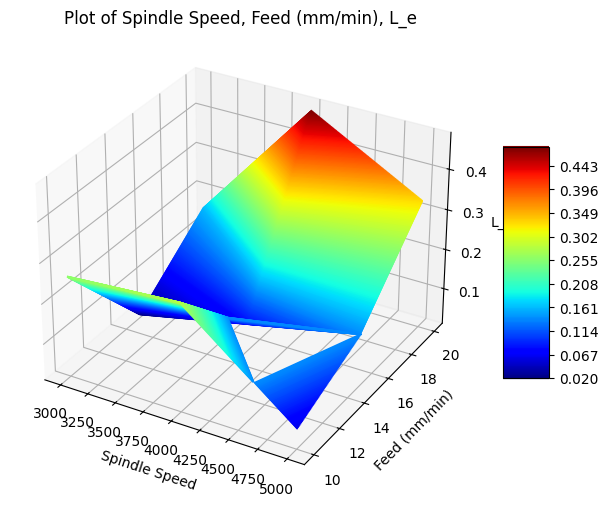

In [123]:
plot_3d_contour(data, "Spindle Speed", "Feed (mm/min)", "L_e")

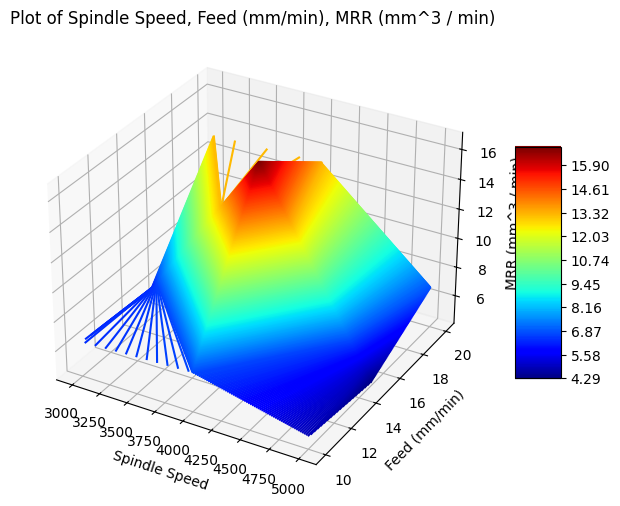

In [124]:
plot_3d_contour(data, "Spindle Speed", "Feed (mm/min)", "MRR (mm^3 / min)")

In [135]:
y_test

,L_e,MRR (mm^3 / min)
18,0.26,0.96
26,0.33,6.86
12,0.36,1.12
0,0.05,1.08
6,0.05,0.81
21,0.10,1.35


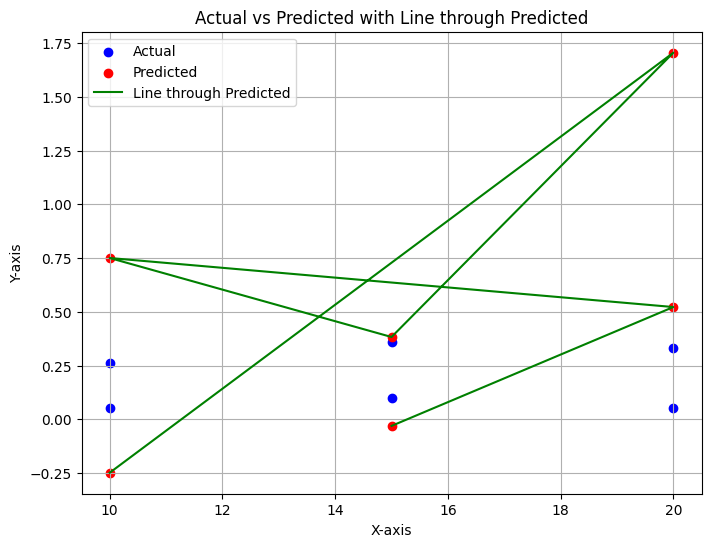

In [138]:
import matplotlib.pyplot as plt

def plot_graph(x, y_test, y_pred):
    plt.figure(figsize=(8, 6))
    
    # Plotting the test data
    plt.scatter(x, y_test, label='Actual', color='blue')
    
    # Plotting the predicted data
    plt.scatter(x, y_pred, label='Predicted', color='red')
    
    # Plotting a line passing through y_pred
    plt.plot(x, y_pred, label='Line through Predicted', color='green')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Actual vs Predicted with Line through Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_graph(X_test['Feed (mm/min)'], y_test['L_e'], y_pred[0])


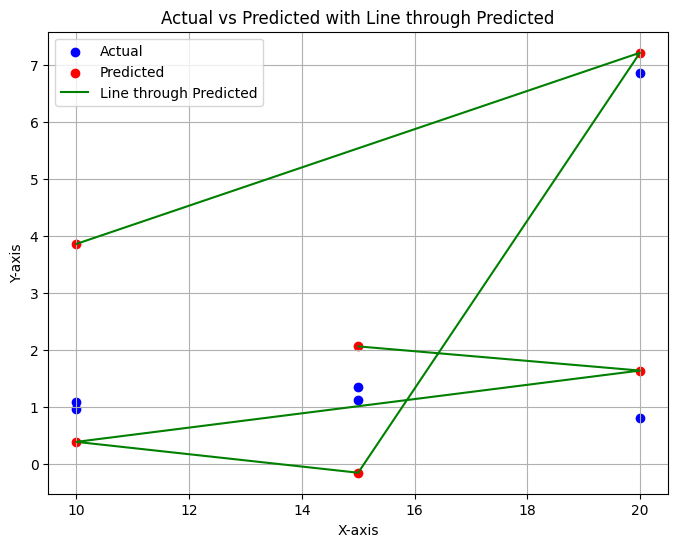

In [139]:
plot_graph(X_test['Feed (mm/min)'], y_test['MRR (mm^3 / min)'], y_pred[1])